In [1]:
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
from torch.functional import F
import time

In [2]:
class Inception(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super().__init__(**kwargs)
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        
        self.p3_1=nn.Conv2d(in_channels,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_channels,c4,kernel_size=1)
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(F.relu(self.p4_1(x))))
        
        return torch.cat((p1,p2,p3,p4),dim=1)
    

In [3]:
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b2=nn.Sequential(nn.Conv2d(64,64,kernel_size=1),
                 nn.ReLU(),
                 nn.Conv2d(64,192,kernel_size=3,padding=1),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b3=nn.Sequential(Inception(192,64,(96,128),(16,32),32),
                 Inception(256,128,(128,192),(32,96),64),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b4=nn.Sequential(Inception(480,192,(96,208),(16,48),64),
                 Inception(512,160,(112,224),(24,64),64),
                 Inception(512,128,(128,256),(24,64),64),
                 Inception(512,112,(144,288),(32,64),64),
                 Inception(528,256,(160,320),(32,128),128),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

b5=nn.Sequential(Inception(832,256,(160,320),(32,128),128),
                 Inception(832,384,(192,384),(48,128),128),
                 nn.AdaptiveAvgPool2d((1,1)),
                 nn.Flatten())

net=nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

In [4]:
X=torch.rand(1,1,96,96)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [5]:
class Accumulator:
    def __init__(self,n):
        self.data=[.0]*n
    
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
        
    def reset(self):
        self.data=[.0]*len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]

In [6]:
argmax=lambda x,*args,**kwargs: x.argmax(*args,**kwargs)
astype=lambda x,*args,**kwargs: x.type(*args,**kwargs)
reduce_sum=lambda x,*args,**kwargs: x.sum(*args,**kwargs)

def accuracy(y_hat,y):
    #独热数字都能用
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=argmax(y_hat,axis=1)
        
    cmp= astype(y_hat,y.dtype)==y
    
    return float(reduce_sum(astype(cmp,y.dtype)))

In [7]:
size=lambda x,*args,**kwargs:x.numel(*args,**kwargs)

def evaluate_accuracy_gpu(net,test_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters()))
    
    metric=Accumulator(2)
    with torch.no_grad():
        for X,y in test_iter:
            if isinstance(X,list):
                X=[x.to(device) for x in X]
            else:
                X=X.to(device)
            y=y.to(device)
            metric.add(accuracy(net(X),y),size(y))
            
    return metric[0]/metric[1]

In [8]:
class Timer:
    def __init__(self):
        self.times=[]
        self.start()
        
    def start(self):
        self.tik=time.time()
    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times)/len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [9]:
def use_svg_display():
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [10]:
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    
    if legend:
        axes.legend(legend)
        
    axes.grid()

In [11]:
class Animator:
    def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,
                 ylim=None,xscale='linear',yscale='linear',
                 fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                 figsize=(3.5,2.5)):
        if legend is None:
            legend=[]
        use_svg_display()
        plt.ion()
        self.fig,self.axes=plt.subplots(nrows,ncols,figsize=figsize)
        
        if nrows*ncols==1:
            self.axes=[self.axes,]
        
        self.config_axes=lambda:set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
        self.X,self.Y,self.fmts=None,None,fmts
    
    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y=[y]
        n=len(y)
        if not hasattr(x,"__len__"):
            x=[x]*n
        if not self.X:
            self.X=[[] for _ in range(n)]
        if not self.Y:
            self.Y=[[] for _ in range(n)]
        #每线加每点
        for i,(a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        self.axes[0].cla()
        #画出每线
        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes()
        
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
def train(net,train_iter,test_iter,num_epochs,lr,device):
    
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    print('training on',device)
    net.to(device)
    
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    
    animator=Animator(xlabel='epoch',xlim=[1,num_epochs],
                      legend=['train loss','train acc','test acc'])
    
    timer,num_batches=Timer(),len(train_iter)
    
    for epoch in range(num_epochs):
        
        metric=Accumulator(3)
        net.train()#模式设置
        for i,(X,y) in enumerate(train_iter):
            timer.start()
            X,y=X.to(device),y.to(device)
            optimizer.zero_grad()
            
            y_hat=net(X)
            l=loss(y_hat,y)
            
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l*X.shape[0],accuracy(y_hat,y),X.shape[0])
            
            timer.stop()
            
            train_l=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            
            if (i+1)%(num_batches//5)==0 or i+1==num_batches:
                animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
                
            
        test_acc=evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
        
    print(f'loss{train_l:.3f},train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples per sec'
          f'on{str(device)}')

In [13]:
def get_dataloader_workers():
    return 1

def load_data_fashion_mnist(batch_size,resize=None):
    trans=[transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans=transforms.Compose(trans)
    
    mnist_train=datasets.FashionMNIST(root='../data',train=True,transform=trans,download=True)
    mnist_test=datasets.FashionMNIST(root='../data',train=False,transform=trans,download=True)
    
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=get_dataloader_workers()))


In [14]:
def try_gpu(i=0):
    if torch.cuda.device_count()>=i+1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

loss0.269,train acc 0.899, test acc 0.891
742.5 examples per seconcuda:0


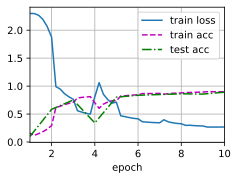

In [15]:
lr,num_epochs,batch_size=0.1,10,128
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=96)
train(net,train_iter,test_iter,num_epochs,lr,try_gpu())